# ASL Recognition: End-to-End Workflow

This notebook consolidates the entire workflow for preprocessing, model training, and evaluation for American Sign Language (ASL) recognition.


In [1]:
# Import Required Libraries
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Preprocessing: Load and Normalize Keypoints

We will load the preprocessed keypoints from the JSON files and normalize them.


In [2]:
# Configuration
DATA_DIR = Path(r'f:\Uni_Stuff\6th_Sem\DL\Proj\video-asl-recognition\pose_estimation\data\keypoints')

# Load and normalize keypoints
def load_keypoints(data_dir):
    data = []
    labels = []
    skipped_files = 0
    processed_files = 0
    print(f"Loading keypoints from {data_dir}")
    # Gather all json files from all label directories
    all_json_files = []
    for label_dir in data_dir.iterdir():
        if label_dir.is_dir():
            all_json_files.extend(list(label_dir.glob('*.json')))
    # Use a single tqdm progress bar for all files
    for json_file in tqdm(all_json_files, desc="Loading keypoint files"):
        try:
            with open(json_file, 'r') as f:
                content = json.load(f)
                if 'keypoints' not in content or 'label' not in content:
                    skipped_files += 1
                    continue
                keypoints = content['keypoints']
                label = content['label']
                processed_frames = []
                for frame in keypoints:
                    left_hand_features = np.zeros(63, dtype=np.float32)
                    right_hand_features = np.zeros(63, dtype=np.float32)
                    pose_features = np.zeros(99, dtype=np.float32)
                    if 'hands' in frame and frame['hands']:
                        for i, hand in enumerate(frame['hands']):
                            if i < 2:
                                hand_features = []
                                for point in hand:
                                    if isinstance(point, list) and len(point) == 3:
                                        hand_features.extend(point)
                                if i == 0 and len(hand_features) <= 63:
                                    left_hand_features[:len(hand_features)] = hand_features
                                elif i == 1 and len(hand_features) <= 63:
                                    right_hand_features[:len(hand_features)] = hand_features
                    if 'pose' in frame and frame['pose']:
                        pose_data = []
                        for point in frame['pose']:
                            if isinstance(point, list) and len(point) == 3:
                                pose_data.extend(point)
                        if len(pose_data) <= 99:
                            pose_features[:len(pose_data)] = pose_data
                    frame_features = np.concatenate([left_hand_features, right_hand_features, pose_features])
                    processed_frames.append(frame_features)
                if processed_frames:
                    processed_data = np.array(processed_frames, dtype=np.float32)
                    if processed_data.shape[0] > 0 and processed_data.shape[1] > 0:
                        data.append(processed_data)
                        labels.append(label)
                        processed_files += 1
                    else:
                        skipped_files += 1
                else:
                    skipped_files += 1
        except Exception as e:
            skipped_files += 1
    print(f"Processed {processed_files} files successfully, skipped {skipped_files} files")
    if not data:
        print("Warning: No valid data was loaded!")
        return np.array([]), np.array([])
    max_seq_len = max(sample.shape[0] for sample in data)
    feature_dim = data[0].shape[1]
    padded_data = []
    for sample in data:
        if sample.shape[0] < max_seq_len:
            padding = np.zeros((max_seq_len - sample.shape[0], feature_dim), dtype=np.float32)
            padded_sample = np.vstack((sample, padding))
        else:
            padded_sample = sample[:max_seq_len]
        padded_data.append(padded_sample)
    return np.array(padded_data), np.array(labels)

In [3]:
# Load data
data, labels = load_keypoints(DATA_DIR)

Loading keypoints from f:\Uni_Stuff\6th_Sem\DL\Proj\video-asl-recognition\pose_estimation\data\keypoints


Loading keypoint files:   1%|          | 28/3202 [00:00<00:27, 115.30it/s]

Loading keypoint files: 100%|██████████| 3202/3202 [00:31<00:00, 101.42it/s]

Processed 3202 files successfully, skipped 0 files


# Dataset Preparation: Train-Test Split

Split the dataset into training, validation, and test sets.


In [4]:
# Import train_test_split if not already imported
from sklearn.model_selection import train_test_split
import numpy as np

# Create a mapping from string labels to numeric indices
label_to_index = {label: idx for idx, label in enumerate(np.unique(labels))}
index_to_label = {idx: label for label, idx in label_to_index.items()}
print(f"Label to index mapping: {label_to_index}")

# Convert string labels to numeric indices
numeric_labels = np.array([label_to_index[label] for label in labels])
print(f"Converted labels to numeric indices.")

# Split the dataset
X_train, X_temp, y_train, y_temp = train_test_split(data, numeric_labels, test_size=0.3, stratify=numeric_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")

Label to index mapping: {'about': 0, 'accident': 1, 'africa': 2, 'again': 3, 'all': 4, 'always': 5, 'animal': 6, 'apple': 7, 'approve': 8, 'argue': 9, 'arrive': 10, 'baby': 11, 'back': 12, 'backpack': 13, 'bad': 14, 'bake': 15, 'balance': 16, 'ball': 17, 'banana': 18, 'bar': 19, 'basketball': 20, 'bath': 21, 'bathroom': 22, 'beard': 23, 'because': 24, 'bed': 25, 'before': 26, 'behind': 27, 'bird': 28, 'birthday': 29, 'black': 30, 'blanket': 31, 'blue': 32, 'book': 33, 'bowling': 34, 'boy': 35, 'bring': 36, 'brother': 37, 'brown': 38, 'business': 39, 'but': 40, 'buy': 41, 'call': 42, 'can': 43, 'candy': 44, 'careful': 45, 'cat': 46, 'catch': 47, 'center': 48, 'cereal': 49, 'chair': 50, 'champion': 51, 'change': 52, 'chat': 53, 'cheat': 54, 'check': 55, 'cheese': 56, 'children': 57, 'christmas': 58, 'city': 59, 'class': 60, 'clock': 61, 'close': 62, 'clothes': 63, 'coffee': 64, 'cold': 65, 'college': 66, 'color': 67, 'computer': 68, 'convince': 69, 'cook': 70, 'cool': 71, 'copy': 72, 'co

In [5]:
# Define the dataset class
class ASLDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# Create the datasets
train_dataset = ASLDataset(X_train, y_train)
val_dataset = ASLDataset(X_val, y_val)

# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model Definition: BiLSTM for Temporal Data

Define a BiLSTM model for ASL recognition.


In [11]:
import torch
import torch.nn as nn
import numpy as np

# Print information about the data shape
print(f"Data shape: {data.shape}")
if len(data) > 0:
    print(f"Each sample has {data[0].shape[0]} frames with {data[0].shape[1]} features per frame")

# Define the RNN model for classification
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_rate=0.3):
        super(RNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(
            input_size, hidden_size, batch_first=True, num_layers=num_layers, dropout=dropout_rate if num_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        # Dropout after RNN output
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.layer_norm(x[:, -1, :])
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Get the input size from the processed data
input_size = data[0].shape[1] if len(data) > 0 else 0
print(f"Input size for the model: {input_size}")
hidden_size = 128
output_size = len(np.unique(labels))
print(f"Number of unique labels (classes): {output_size}")

model = RNNModel(input_size, hidden_size, output_size)
print(model)
model = model.to(device)

Data shape: (3202, 60, 225)
Each sample has 60 frames with 225 features per frame
Input size for the model: 225
Number of unique labels (classes): 300
RNNModel(
  (rnn): RNN(225, 128, num_layers=2, batch_first=True, dropout=0.3)
  (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (fc): Linear(in_features=128, out_features=300, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


# Hyperparameter Tuning with Random Search

We use a custom random search implementation for hyperparameter optimization instead of Optuna.


Starting hyperparameter optimization using Random Search...

Trial 1/20
Parameters:
  learning_rate: 0.0007758264346076069
  hidden_size: 16
  dropout_rate: 0.2282980353444978
  batch_size: 4
  weight_decay: 0.0002585901981813174
  num_layers: 3


Epoch 1/20, Train Loss: 5.8675, Val Loss: 5.7851


Epoch 2/20, Train Loss: 5.7610, Val Loss: 5.7217


Epoch 3/20, Train Loss: 5.7237, Val Loss: 5.7107


Epoch 4/20, Train Loss: 5.7137, Val Loss: 5.7018


Epoch 5/20, Train Loss: 5.7069, Val Loss: 5.7141
Early stopping counter: 1/5


Epoch 6/20, Train Loss: 5.7014, Val Loss: 5.7053
Early stopping counter: 2/5


Epoch 7/20, Train Loss: 5.6870, Val Loss: 5.7156
Early stopping counter: 3/5


Epoch 8/20, Train Loss: 5.6754, Val Loss: 5.7117
Early stopping counter: 4/5


Epoch 9/20, Train Loss: 5.6596, Val Loss: 5.7223
Early stopping counter: 5/5
Early stopping triggered.
New best validation loss: 5.7018

Trial 2/20
Parameters:
  learning_rate: 0.006384315197809536
  hidden_size: 64
  dropout_rate: 0.32442103339364525
  batch_size: 8
  weight_decay: 0.0021243264358418415
  num_layers: 3


Epoch 1/20, Train Loss: 5.9501, Val Loss: 5.7168


Epoch 2/20, Train Loss: 5.7303, Val Loss: 5.7032


Epoch 3/20, Train Loss: 5.7200, Val Loss: 5.7060
Early stopping counter: 1/5


Epoch 4/20, Train Loss: 5.7213, Val Loss: 5.7016


Epoch 5/20, Train Loss: 5.7076, Val Loss: 5.6923


Epoch 6/20, Train Loss: 5.7054, Val Loss: 5.6914


Epoch 7/20, Train Loss: 5.7053, Val Loss: 5.6895


Epoch 8/20, Train Loss: 5.7042, Val Loss: 5.6888


Epoch 9/20, Train Loss: 5.7051, Val Loss: 5.6892
Early stopping counter: 1/5


Epoch 10/20, Train Loss: 5.7055, Val Loss: 5.6965
Early stopping counter: 2/5


Epoch 11/20, Train Loss: 5.7081, Val Loss: 5.6896
Early stopping counter: 3/5


Epoch 12/20, Train Loss: 5.7076, Val Loss: 5.6927
Early stopping counter: 4/5


Epoch 13/20, Train Loss: 5.7066, Val Loss: 5.6902
Early stopping counter: 5/5
Early stopping triggered.
New best validation loss: 5.6888

Trial 3/20
Parameters:
  learning_rate: 0.03938807729586887
  hidden_size: 16
  dropout_rate: 0.5356900992097251
  batch_size: 16
  weight_decay: 0.007166392038580177
  num_layers: 3


Epoch 1/20, Train Loss: 5.7927, Val Loss: 5.7168


Epoch 2/20, Train Loss: 5.7341, Val Loss: 5.6992


Epoch 3/20, Train Loss: 5.7397, Val Loss: 5.7084
Early stopping counter: 1/5


Epoch 4/20, Train Loss: 5.7458, Val Loss: 5.7044
Early stopping counter: 2/5


Epoch 5/20, Train Loss: 5.7457, Val Loss: 5.7448
Early stopping counter: 3/5


Epoch 6/20, Train Loss: 5.7452, Val Loss: 5.7500
Early stopping counter: 4/5


Epoch 7/20, Train Loss: 5.7464, Val Loss: 5.7177
Early stopping counter: 5/5
Early stopping triggered.

Trial 4/20
Parameters:
  learning_rate: 0.000583162529917645
  hidden_size: 64
  dropout_rate: 0.7926474286756231
  batch_size: 64
  weight_decay: 0.0001868083962782818
  num_layers: 2


Epoch 1/20, Train Loss: 5.8545, Val Loss: 5.7720


Epoch 2/20, Train Loss: 5.7628, Val Loss: 5.7362


Epoch 3/20, Train Loss: 5.7148, Val Loss: 5.7141


Epoch 4/20, Train Loss: 5.6846, Val Loss: 5.7132


Epoch 5/20, Train Loss: 5.6635, Val Loss: 5.7256
Early stopping counter: 1/5


Epoch 6/20, Train Loss: 5.6575, Val Loss: 5.7287
Early stopping counter: 2/5


Epoch 7/20, Train Loss: 5.6333, Val Loss: 5.7409
Early stopping counter: 3/5


Epoch 8/20, Train Loss: 5.6181, Val Loss: 5.7553
Early stopping counter: 4/5


Epoch 9/20, Train Loss: 5.5800, Val Loss: 5.7599
Early stopping counter: 5/5
Early stopping triggered.

Trial 5/20
Parameters:
  learning_rate: 0.05467763730088678
  hidden_size: 32
  dropout_rate: 0.3302717322669044
  batch_size: 64
  weight_decay: 0.004033051983995965
  num_layers: 2


Epoch 1/20, Train Loss: 5.9150, Val Loss: 5.7314


Epoch 2/20, Train Loss: 5.7525, Val Loss: 5.7537
Early stopping counter: 1/5


Epoch 3/20, Train Loss: 5.7627, Val Loss: 5.7447
Early stopping counter: 2/5


Epoch 4/20, Train Loss: 5.7678, Val Loss: 5.7555
Early stopping counter: 3/5


Epoch 5/20, Train Loss: 5.7500, Val Loss: 5.7102


Epoch 6/20, Train Loss: 5.7542, Val Loss: 5.7971
Early stopping counter: 1/5


Epoch 7/20, Train Loss: 5.7427, Val Loss: 5.7558
Early stopping counter: 2/5


Epoch 8/20, Train Loss: 5.7602, Val Loss: 5.7357
Early stopping counter: 3/5


Epoch 9/20, Train Loss: 5.7327, Val Loss: 5.7291
Early stopping counter: 4/5


Epoch 10/20, Train Loss: 5.7570, Val Loss: 5.8152
Early stopping counter: 5/5
Early stopping triggered.

Trial 6/20
Parameters:
  learning_rate: 0.07827631373910623
  hidden_size: 32
  dropout_rate: 0.3460513227641768
  batch_size: 16
  weight_decay: 0.00040808104849257484
  num_layers: 2


Epoch 1/20, Train Loss: 6.0747, Val Loss: 5.8117


Epoch 2/20, Train Loss: 5.9167, Val Loss: 5.7989


Epoch 3/20, Train Loss: 5.9042, Val Loss: 5.9130
Early stopping counter: 1/5


Epoch 4/20, Train Loss: 5.9462, Val Loss: 5.9065
Early stopping counter: 2/5


Epoch 5/20, Train Loss: 5.9280, Val Loss: 5.8102
Early stopping counter: 3/5


Epoch 6/20, Train Loss: 5.9205, Val Loss: 5.7660


Epoch 7/20, Train Loss: 5.9316, Val Loss: 5.7712
Early stopping counter: 1/5


Epoch 8/20, Train Loss: 5.9433, Val Loss: 5.7562


Epoch 9/20, Train Loss: 5.9093, Val Loss: 5.7722
Early stopping counter: 1/5


Epoch 10/20, Train Loss: 5.8969, Val Loss: 5.7807
Early stopping counter: 2/5


Epoch 11/20, Train Loss: 5.9351, Val Loss: 5.9219
Early stopping counter: 3/5


Epoch 12/20, Train Loss: 5.9325, Val Loss: 5.8968
Early stopping counter: 4/5


Epoch 13/20, Train Loss: 5.9148, Val Loss: 5.8686
Early stopping counter: 5/5
Early stopping triggered.

Trial 7/20
Parameters:
  learning_rate: 0.01766173876523535
  hidden_size: 64
  dropout_rate: 0.6427554989926216
  batch_size: 8
  weight_decay: 0.0017859067143780197
  num_layers: 3


Epoch 1/20, Train Loss: 5.9363, Val Loss: 5.7087


Epoch 2/20, Train Loss: 5.7544, Val Loss: 5.7575
Early stopping counter: 1/5


Epoch 3/20, Train Loss: 5.7433, Val Loss: 5.6941


Epoch 4/20, Train Loss: 5.7417, Val Loss: 5.6991
Early stopping counter: 1/5


Epoch 5/20, Train Loss: 5.7463, Val Loss: 5.7028
Early stopping counter: 2/5


Epoch 6/20, Train Loss: 5.7466, Val Loss: 5.6910


Epoch 7/20, Train Loss: 5.7431, Val Loss: 5.7148
Early stopping counter: 1/5


Epoch 8/20, Train Loss: 5.7502, Val Loss: 5.6999
Early stopping counter: 2/5


Epoch 9/20, Train Loss: 5.7425, Val Loss: 5.6956
Early stopping counter: 3/5


Epoch 10/20, Train Loss: 5.7487, Val Loss: 5.7171
Early stopping counter: 4/5


Epoch 11/20, Train Loss: 5.7493, Val Loss: 5.7126
Early stopping counter: 5/5
Early stopping triggered.

Trial 8/20
Parameters:
  learning_rate: 0.011304402154750235
  hidden_size: 16
  dropout_rate: 0.4375366976500005
  batch_size: 8
  weight_decay: 0.00027464860377247934
  num_layers: 1


Epoch 1/20, Train Loss: 5.8388, Val Loss: 5.7181


Epoch 2/20, Train Loss: 5.7318, Val Loss: 5.7161


Epoch 3/20, Train Loss: 5.7281, Val Loss: 5.7112


Epoch 4/20, Train Loss: 5.7156, Val Loss: 5.7188
Early stopping counter: 1/5


Epoch 5/20, Train Loss: 5.7117, Val Loss: 5.7238
Early stopping counter: 2/5


Epoch 6/20, Train Loss: 5.7141, Val Loss: 5.7292
Early stopping counter: 3/5


Epoch 7/20, Train Loss: 5.7072, Val Loss: 5.7093


Epoch 8/20, Train Loss: 5.7040, Val Loss: 5.7195
Early stopping counter: 1/5


Epoch 9/20, Train Loss: 5.7003, Val Loss: 5.7198
Early stopping counter: 2/5


Epoch 10/20, Train Loss: 5.6900, Val Loss: 5.7611
Early stopping counter: 3/5


Epoch 11/20, Train Loss: 5.6944, Val Loss: 5.7353
Early stopping counter: 4/5


Epoch 12/20, Train Loss: 5.6886, Val Loss: 5.7694
Early stopping counter: 5/5
Early stopping triggered.

Trial 9/20
Parameters:
  learning_rate: 0.00017123607846700436
  hidden_size: 32
  dropout_rate: 0.6044510459488359
  batch_size: 32
  weight_decay: 0.00902182506821204
  num_layers: 3


Epoch 1/20, Train Loss: 5.8597, Val Loss: 5.8275


Epoch 2/20, Train Loss: 5.8143, Val Loss: 5.7926


Epoch 3/20, Train Loss: 5.7694, Val Loss: 5.7684


Epoch 4/20, Train Loss: 5.7473, Val Loss: 5.7557


Epoch 5/20, Train Loss: 5.7230, Val Loss: 5.7448


Epoch 6/20, Train Loss: 5.7134, Val Loss: 5.7359


Epoch 7/20, Train Loss: 5.7071, Val Loss: 5.7296


Epoch 8/20, Train Loss: 5.6999, Val Loss: 5.7272


Epoch 9/20, Train Loss: 5.6823, Val Loss: 5.7214


Epoch 10/20, Train Loss: 5.6711, Val Loss: 5.7192


Epoch 11/20, Train Loss: 5.6638, Val Loss: 5.7186


Epoch 12/20, Train Loss: 5.6696, Val Loss: 5.7173


Epoch 13/20, Train Loss: 5.6515, Val Loss: 5.7147


Epoch 14/20, Train Loss: 5.6577, Val Loss: 5.7181
Early stopping counter: 1/5


Epoch 15/20, Train Loss: 5.6513, Val Loss: 5.7155
Early stopping counter: 2/5


Epoch 16/20, Train Loss: 5.6329, Val Loss: 5.7158
Early stopping counter: 3/5


Epoch 17/20, Train Loss: 5.6276, Val Loss: 5.7129


Epoch 18/20, Train Loss: 5.6168, Val Loss: 5.7173
Early stopping counter: 1/5


Epoch 19/20, Train Loss: 5.6135, Val Loss: 5.7152
Early stopping counter: 2/5


Epoch 20/20, Train Loss: 5.6070, Val Loss: 5.7162
Early stopping counter: 3/5

Trial 10/20
Parameters:
  learning_rate: 0.004507576767546589
  hidden_size: 64
  dropout_rate: 0.2260187651551098
  batch_size: 64
  weight_decay: 0.001986110624026645
  num_layers: 3


Epoch 1/20, Train Loss: 5.8716, Val Loss: 5.8777


Epoch 2/20, Train Loss: 5.8725, Val Loss: 5.7278


Epoch 3/20, Train Loss: 5.8265, Val Loss: 5.7077


Epoch 4/20, Train Loss: 5.7912, Val Loss: 5.7028


Epoch 5/20, Train Loss: 5.7663, Val Loss: 5.7023


Epoch 6/20, Train Loss: 5.7538, Val Loss: 5.6990


Epoch 7/20, Train Loss: 5.7499, Val Loss: 5.7025
Early stopping counter: 1/5


Epoch 8/20, Train Loss: 5.7303, Val Loss: 5.6937


Epoch 9/20, Train Loss: 5.7200, Val Loss: 5.6969
Early stopping counter: 1/5


Epoch 10/20, Train Loss: 5.7127, Val Loss: 5.6979
Early stopping counter: 2/5


Epoch 11/20, Train Loss: 5.7092, Val Loss: 5.6964
Early stopping counter: 3/5


Epoch 12/20, Train Loss: 5.6992, Val Loss: 5.6971
Early stopping counter: 4/5


Epoch 13/20, Train Loss: 5.6954, Val Loss: 5.6970
Early stopping counter: 5/5
Early stopping triggered.

Trial 11/20
Parameters:
  learning_rate: 0.014066321855597962
  hidden_size: 16
  dropout_rate: 0.7008708771620158
  batch_size: 8
  weight_decay: 0.003304861498730906
  num_layers: 1


Epoch 1/20, Train Loss: 5.8018, Val Loss: 5.7053


Epoch 2/20, Train Loss: 5.7272, Val Loss: 5.7014


Epoch 3/20, Train Loss: 5.7226, Val Loss: 5.6931


Epoch 4/20, Train Loss: 5.7209, Val Loss: 5.6930


Epoch 5/20, Train Loss: 5.7210, Val Loss: 5.6909


Epoch 6/20, Train Loss: 5.7208, Val Loss: 5.6995
Early stopping counter: 1/5


Epoch 7/20, Train Loss: 5.7272, Val Loss: 5.6934
Early stopping counter: 2/5


Epoch 8/20, Train Loss: 5.7217, Val Loss: 5.6946
Early stopping counter: 3/5


Epoch 9/20, Train Loss: 5.7212, Val Loss: 5.6905


Epoch 10/20, Train Loss: 5.7239, Val Loss: 5.6927
Early stopping counter: 1/5


Epoch 11/20, Train Loss: 5.7231, Val Loss: 5.6924
Early stopping counter: 2/5


Epoch 12/20, Train Loss: 5.7239, Val Loss: 5.6969
Early stopping counter: 3/5


Epoch 13/20, Train Loss: 5.7254, Val Loss: 5.6962
Early stopping counter: 4/5


Epoch 14/20, Train Loss: 5.7236, Val Loss: 5.6940
Early stopping counter: 5/5
Early stopping triggered.

Trial 12/20
Parameters:
  learning_rate: 0.010596779713796679
  hidden_size: 16
  dropout_rate: 0.6398293093481544
  batch_size: 16
  weight_decay: 0.0002552747230118151
  num_layers: 2


Epoch 1/20, Train Loss: 5.8286, Val Loss: 5.7281


Epoch 2/20, Train Loss: 5.7207, Val Loss: 5.7083


Epoch 3/20, Train Loss: 5.7127, Val Loss: 5.6979


Epoch 4/20, Train Loss: 5.7001, Val Loss: 5.7083
Early stopping counter: 1/5


Epoch 5/20, Train Loss: 5.7117, Val Loss: 5.7112
Early stopping counter: 2/5


Epoch 6/20, Train Loss: 5.6939, Val Loss: 5.7454
Early stopping counter: 3/5


Epoch 7/20, Train Loss: 5.6845, Val Loss: 5.7342
Early stopping counter: 4/5


Epoch 8/20, Train Loss: 5.6860, Val Loss: 5.7309
Early stopping counter: 5/5
Early stopping triggered.

Trial 13/20
Parameters:
  learning_rate: 0.08123059881870967
  hidden_size: 64
  dropout_rate: 0.38570296101307533
  batch_size: 4
  weight_decay: 0.0012787569225841421
  num_layers: 1


Epoch 1/20, Train Loss: 6.4031, Val Loss: 6.0256


Epoch 2/20, Train Loss: 6.2365, Val Loss: 6.4179
Early stopping counter: 1/5


Epoch 3/20, Train Loss: 6.2269, Val Loss: 6.3483
Early stopping counter: 2/5


Epoch 4/20, Train Loss: 6.1859, Val Loss: 6.2132
Early stopping counter: 3/5


Epoch 5/20, Train Loss: 6.2577, Val Loss: 6.3279
Early stopping counter: 4/5


Epoch 6/20, Train Loss: 6.2021, Val Loss: 5.9649


Epoch 7/20, Train Loss: 6.2697, Val Loss: 5.9193


Epoch 8/20, Train Loss: 6.2047, Val Loss: 6.0025
Early stopping counter: 1/5


Epoch 9/20, Train Loss: 6.2806, Val Loss: 6.1389
Early stopping counter: 2/5


Epoch 10/20, Train Loss: 6.2976, Val Loss: 5.9777
Early stopping counter: 3/5


Epoch 11/20, Train Loss: 6.2294, Val Loss: 6.1170
Early stopping counter: 4/5


Epoch 12/20, Train Loss: 6.2651, Val Loss: 6.1912
Early stopping counter: 5/5
Early stopping triggered.

Trial 14/20
Parameters:
  learning_rate: 0.0021669349973955443
  hidden_size: 16
  dropout_rate: 0.3066304809612442
  batch_size: 8
  weight_decay: 0.0014800640721837031
  num_layers: 2


Epoch 1/20, Train Loss: 5.8593, Val Loss: 5.7144


Epoch 2/20, Train Loss: 5.7443, Val Loss: 5.6977


Epoch 3/20, Train Loss: 5.7218, Val Loss: 5.6966


Epoch 4/20, Train Loss: 5.7122, Val Loss: 5.6989
Early stopping counter: 1/5


Epoch 5/20, Train Loss: 5.7026, Val Loss: 5.7096
Early stopping counter: 2/5


Epoch 6/20, Train Loss: 5.6949, Val Loss: 5.7197
Early stopping counter: 3/5


Epoch 7/20, Train Loss: 5.6898, Val Loss: 5.7297
Early stopping counter: 4/5


Epoch 8/20, Train Loss: 5.6815, Val Loss: 5.7382
Early stopping counter: 5/5
Early stopping triggered.

Trial 15/20
Parameters:
  learning_rate: 0.0006536025739023861
  hidden_size: 64
  dropout_rate: 0.7656168526767761
  batch_size: 16
  weight_decay: 0.0005761333840074518
  num_layers: 3


Epoch 1/20, Train Loss: 5.8773, Val Loss: 5.7318


Epoch 2/20, Train Loss: 5.7612, Val Loss: 5.7201


Epoch 3/20, Train Loss: 5.7399, Val Loss: 5.7087


Epoch 4/20, Train Loss: 5.7250, Val Loss: 5.7145
Early stopping counter: 1/5


Epoch 5/20, Train Loss: 5.7034, Val Loss: 5.7372
Early stopping counter: 2/5


Epoch 6/20, Train Loss: 5.6901, Val Loss: 5.7436
Early stopping counter: 3/5


Epoch 7/20, Train Loss: 5.6543, Val Loss: 5.7444
Early stopping counter: 4/5


Epoch 8/20, Train Loss: 5.6115, Val Loss: 5.7500
Early stopping counter: 5/5
Early stopping triggered.

Trial 16/20
Parameters:
  learning_rate: 0.03625867295497067
  hidden_size: 16
  dropout_rate: 0.5959729404873993
  batch_size: 32
  weight_decay: 0.0006012370999113436
  num_layers: 2


Epoch 1/20, Train Loss: 5.8502, Val Loss: 5.7083


Epoch 2/20, Train Loss: 5.7392, Val Loss: 5.7537
Early stopping counter: 1/5


Epoch 3/20, Train Loss: 5.7506, Val Loss: 5.7137
Early stopping counter: 2/5


Epoch 4/20, Train Loss: 5.7381, Val Loss: 5.7265
Early stopping counter: 3/5


Epoch 5/20, Train Loss: 5.7371, Val Loss: 5.7169
Early stopping counter: 4/5


Epoch 6/20, Train Loss: 5.7487, Val Loss: 5.7268
Early stopping counter: 5/5
Early stopping triggered.

Trial 17/20
Parameters:
  learning_rate: 0.022630343545880307
  hidden_size: 32
  dropout_rate: 0.6234815225127552
  batch_size: 16
  weight_decay: 0.001032716061109334
  num_layers: 3


Epoch 1/20, Train Loss: 5.8573, Val Loss: 5.7006


Epoch 2/20, Train Loss: 5.7467, Val Loss: 5.7121
Early stopping counter: 1/5


Epoch 3/20, Train Loss: 5.7400, Val Loss: 5.7189
Early stopping counter: 2/5


Epoch 4/20, Train Loss: 5.7461, Val Loss: 5.7241
Early stopping counter: 3/5


Epoch 5/20, Train Loss: 5.7441, Val Loss: 5.7020
Early stopping counter: 4/5


Epoch 6/20, Train Loss: 5.7385, Val Loss: 5.7073
Early stopping counter: 5/5
Early stopping triggered.

Trial 18/20
Parameters:
  learning_rate: 0.00013817924241398978
  hidden_size: 32
  dropout_rate: 0.7465254009805309
  batch_size: 32
  weight_decay: 0.00011661535247193174
  num_layers: 1


Epoch 1/20, Train Loss: 5.8770, Val Loss: 5.8504


Epoch 2/20, Train Loss: 5.8337, Val Loss: 5.8246


Epoch 3/20, Train Loss: 5.8029, Val Loss: 5.8074


Epoch 4/20, Train Loss: 5.7989, Val Loss: 5.7948


Epoch 5/20, Train Loss: 5.7670, Val Loss: 5.7875


Epoch 6/20, Train Loss: 5.7545, Val Loss: 5.7795


Epoch 7/20, Train Loss: 5.7380, Val Loss: 5.7721


Epoch 8/20, Train Loss: 5.7267, Val Loss: 5.7669


Epoch 9/20, Train Loss: 5.7144, Val Loss: 5.7646


Epoch 10/20, Train Loss: 5.7128, Val Loss: 5.7618


Epoch 11/20, Train Loss: 5.7097, Val Loss: 5.7604


Epoch 12/20, Train Loss: 5.6985, Val Loss: 5.7590


Epoch 13/20, Train Loss: 5.6924, Val Loss: 5.7588


Epoch 14/20, Train Loss: 5.6778, Val Loss: 5.7577


Epoch 15/20, Train Loss: 5.6776, Val Loss: 5.7586
Early stopping counter: 1/5


Epoch 16/20, Train Loss: 5.6716, Val Loss: 5.7562


Epoch 17/20, Train Loss: 5.6693, Val Loss: 5.7564
Early stopping counter: 1/5


Epoch 18/20, Train Loss: 5.6624, Val Loss: 5.7568
Early stopping counter: 2/5


Epoch 19/20, Train Loss: 5.6619, Val Loss: 5.7561


Epoch 20/20, Train Loss: 5.6529, Val Loss: 5.7562
Early stopping counter: 1/5

Trial 19/20
Parameters:
  learning_rate: 0.005594900466292766
  hidden_size: 16
  dropout_rate: 0.6310049809182801
  batch_size: 8
  weight_decay: 0.002314155958795756
  num_layers: 3


Epoch 1/20, Train Loss: 5.8379, Val Loss: 5.7076


Epoch 2/20, Train Loss: 5.7206, Val Loss: 5.7077
Early stopping counter: 1/5


Epoch 3/20, Train Loss: 5.7102, Val Loss: 5.6948


Epoch 4/20, Train Loss: 5.7104, Val Loss: 5.6947


Epoch 5/20, Train Loss: 5.7062, Val Loss: 5.6927


Epoch 6/20, Train Loss: 5.7038, Val Loss: 5.6901


Epoch 7/20, Train Loss: 5.7026, Val Loss: 5.6899


Epoch 8/20, Train Loss: 5.7013, Val Loss: 5.6898


Epoch 9/20, Train Loss: 5.7026, Val Loss: 5.6905
Early stopping counter: 1/5


Epoch 10/20, Train Loss: 5.7017, Val Loss: 5.6909
Early stopping counter: 2/5


Epoch 11/20, Train Loss: 5.7020, Val Loss: 5.6896


Epoch 12/20, Train Loss: 5.7020, Val Loss: 5.6904
Early stopping counter: 1/5


Epoch 13/20, Train Loss: 5.7022, Val Loss: 5.6892


Epoch 14/20, Train Loss: 5.7007, Val Loss: 5.6987
Early stopping counter: 1/5


Epoch 15/20, Train Loss: 5.7035, Val Loss: 5.6969
Early stopping counter: 2/5


Epoch 16/20, Train Loss: 5.7032, Val Loss: 5.6892
Early stopping counter: 3/5


Epoch 17/20, Train Loss: 5.7011, Val Loss: 5.6909
Early stopping counter: 4/5


Epoch 18/20, Train Loss: 5.7021, Val Loss: 5.6894
Early stopping counter: 5/5
Early stopping triggered.

Trial 20/20
Parameters:
  learning_rate: 0.057442920022539506
  hidden_size: 32
  dropout_rate: 0.6673512498385898
  batch_size: 32
  weight_decay: 0.0005760886226692032
  num_layers: 3


Epoch 1/20, Train Loss: 5.9317, Val Loss: 5.7960


Epoch 2/20, Train Loss: 5.7920, Val Loss: 5.7619


Epoch 3/20, Train Loss: 5.7899, Val Loss: 5.8907
Early stopping counter: 1/5


Epoch 4/20, Train Loss: 5.8096, Val Loss: 5.7665
Early stopping counter: 2/5


Epoch 5/20, Train Loss: 5.7818, Val Loss: 5.8137
Early stopping counter: 3/5


Epoch 6/20, Train Loss: 5.8293, Val Loss: 5.7897
Early stopping counter: 4/5


Epoch 7/20, Train Loss: 5.8488, Val Loss: 5.7318


Epoch 8/20, Train Loss: 5.8063, Val Loss: 5.7625
Early stopping counter: 1/5


Epoch 9/20, Train Loss: 5.7980, Val Loss: 5.8677
Early stopping counter: 2/5


Epoch 10/20, Train Loss: 5.8090, Val Loss: 5.7450
Early stopping counter: 3/5


Epoch 11/20, Train Loss: 5.7934, Val Loss: 5.7487
Early stopping counter: 4/5


Epoch 12/20, Train Loss: 5.7985, Val Loss: 5.7341
Early stopping counter: 5/5
Early stopping triggered.

Random Search completed.
Best validation loss: 5.6888
Best parameters:
  learning_rate: 0.006384315197809536
  hidden_size: 64
  dropout_rate: 0.32442103339364525
  batch_size: 8
  weight_decay: 0.0021243264358418415
  num_layers: 3

Best trial:
  Value (validation loss): 5.6888
  Params:
    learning_rate: 0.006384315197809536
    hidden_size: 64
    dropout_rate: 0.32442103339364525
    batch_size: 8
    weight_decay: 0.0021243264358418415
    num_layers: 3


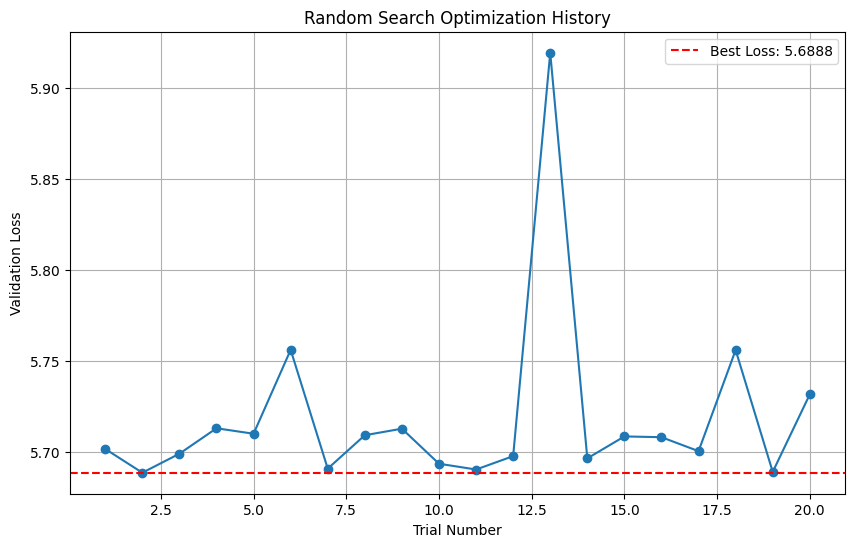

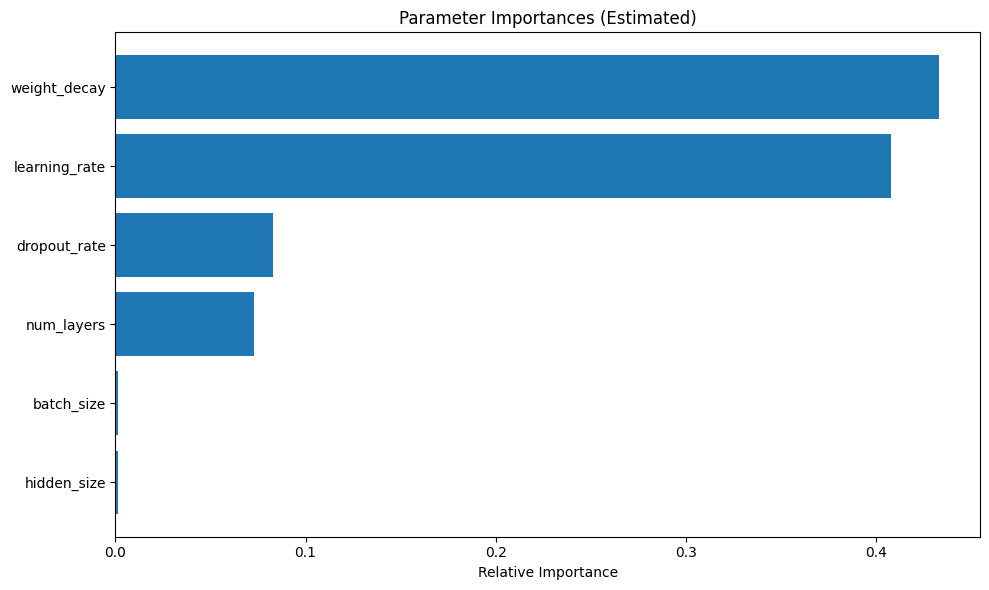

In [7]:
# Import the random search implementation
from random_search_implementation import random_search_hyperparameter_optimization, plot_random_search_results
import numpy as np

print("Starting hyperparameter optimization using Random Search...")

# Run random search for hyperparameter optimization
best_params, results = random_search_hyperparameter_optimization(
    model_class=RNNModel,
    input_size=input_size,
    output_size=output_size,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    device=device,
    n_trials=20,
    max_time_seconds=3600  # Run for max of 1 hour
)

# Extract best validation loss
best_val_loss = min(r['val_loss'] for r in results)

# Print optimization results
print("\nBest trial:")
print(f"  Value (validation loss): {best_val_loss:.4f}")
print("  Params:")
for key, value in best_params.items():
    print(f"    {key}: {value}")

# Ensure all required parameters are stored for model training
best_params = {
    'learning_rate': best_params['learning_rate'],
    'hidden_size': best_params['hidden_size'],
    'dropout_rate': best_params['dropout_rate'],
    'batch_size': best_params['batch_size'],
    'weight_decay': best_params['weight_decay'],
    'num_layers': best_params['num_layers']
}

# Visualize the results
plot_random_search_results(results)

# Model Training with K-Fold Cross-Validation

Train the model using k-fold cross-validation to better evaluate its performance. This section also switches to an RNN-based architecture and ensures proper batch normalization.


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from tqdm import tqdm

# Define the RNN model for classification
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2, dropout_rate=0.3):
        super(RNNModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(
            input_size, hidden_size, batch_first=True, num_layers=num_layers, dropout=dropout_rate if num_layers > 1 else 0
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        # Dropout after RNN output
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x, _ = self.rnn(x)
        x = self.layer_norm(x[:, -1, :])
        x = self.dropout(x)
        x = self.fc(x)
        return x

# Use best hyperparameters from Random Search tuning
"""best_lr = best_params['learning_rate']
best_hidden_size = best_params['hidden_size']
best_dropout_rate = best_params['dropout_rate']
best_batch_size = max(2, best_params['batch_size'])  # Ensure batch size is above 1
best_weight_decay = best_params['weight_decay']
best_num_layers = best_params['num_layers']"""

best_lr = 0.01
best_hidden_size = 32
best_dropout_rate = 0.4
best_batch_size = 32
best_weight_decay = 0.0001
best_num_layers = 5

print(f"Training with best hyperparameters:")
print(f"  Learning rate: {best_lr}")
print(f"  Hidden size: {best_hidden_size}")
print(f"  Dropout rate: {best_dropout_rate}")
print(f"  Batch size: {best_batch_size}")
print(f"  Weight decay: {best_weight_decay}")
print(f"  Number of layers: {best_num_layers}")

# Initialize k-fold cross-validation
k_folds = 3
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Training with k-fold cross-validation
fold_results = []
for fold, (train_idx, val_idx) in enumerate(kf.split(train_dataset)):
    print(f"Fold {fold+1}/{k_folds}")

    # Create data loaders for the current fold
    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)
    train_loader = DataLoader(train_subset, batch_size=best_batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=best_batch_size, shuffle=False)

    # Recreate model for each fold with best hyperparameters
    model = RNNModel(
        input_size, best_hidden_size, output_size, num_layers=best_num_layers, dropout_rate=best_dropout_rate).to(device)

    # Define the loss function and optimizer with weight decay
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)
    # Use ReduceLROnPlateau scheduler for better learning rate adaptation
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    # Training loop
    train_losses = []
    val_losses = []
    patience = 10
    early_stop_counter = 0
    best_val_loss = float('inf')
    epochs = 50
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc="Training", leave=False):
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validation", leave=False):
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        # Step the scheduler
        scheduler.step(val_loss)

        # Save the model if validation loss improves
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"best_model_fold{fold+1}.pth")
            print("Model checkpoint saved!")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            print(f"Early stopping counter: {early_stop_counter}/{patience}")
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    fold_results.append(best_val_loss)

# Print cross-validation results
print("\nCross-validation results:")
for fold, loss in enumerate(fold_results):
    print(f"Fold {fold+1}: Validation Loss = {loss:.4f}")
print(f"Average Validation Loss: {sum(fold_results)/len(fold_results):.4f}")

Training with best hyperparameters:
  Learning rate: 0.01
  Hidden size: 32
  Dropout rate: 0.4
  Batch size: 32
  Weight decay: 0.0001
  Number of layers: 5
Fold 1/3
Epoch 1/50


Epoch 1/50, Train Loss: 5.9660, Val Loss: 5.8442
Model checkpoint saved!
Epoch 2/50


Epoch 2/50, Train Loss: 5.8236, Val Loss: 5.8449
Early stopping counter: 1/10
Epoch 3/50


Epoch 3/50, Train Loss: 5.7096, Val Loss: 5.8002
Model checkpoint saved!
Epoch 4/50


Epoch 4/50, Train Loss: 5.6878, Val Loss: 5.8142
Early stopping counter: 1/10
Epoch 5/50


Epoch 5/50, Train Loss: 5.6825, Val Loss: 5.8165
Early stopping counter: 2/10
Epoch 6/50


Epoch 6/50, Train Loss: 5.6844, Val Loss: 5.8077
Early stopping counter: 3/10
Epoch 7/50


Epoch 7/50, Train Loss: 5.6754, Val Loss: 5.8261
Early stopping counter: 4/10
Epoch 8/50


Epoch 8/50, Train Loss: 5.6760, Val Loss: 5.8212
Early stopping counter: 5/10
Epoch 9/50


Epoch 9/50, Train Loss: 5.6776, Val Loss: 5.8177
Early stopping counter: 6/10
Epoch 10/50


Epoch 10/50, Train Loss: 5.6630, Val Loss: 5.8447
Early stopping counter: 7/10
Epoch 11/50


Epoch 11/50, Train Loss: 5.6648, Val Loss: 5.8412
Early stopping counter: 8/10
Epoch 12/50


Epoch 12/50, Train Loss: 5.6638, Val Loss: 5.8476
Early stopping counter: 9/10
Epoch 13/50


Epoch 13/50, Train Loss: 5.6631, Val Loss: 5.8480
Early stopping counter: 10/10
Early stopping triggered.
Fold 2/3
Epoch 1/50


Epoch 1/50, Train Loss: 5.9569, Val Loss: 5.8696
Model checkpoint saved!
Epoch 2/50


Epoch 2/50, Train Loss: 5.8311, Val Loss: 5.8707
Early stopping counter: 1/10
Epoch 3/50


Epoch 3/50, Train Loss: 5.7088, Val Loss: 5.8194
Model checkpoint saved!
Epoch 4/50


Epoch 4/50, Train Loss: 5.6750, Val Loss: 5.8503
Early stopping counter: 1/10
Epoch 5/50


Epoch 5/50, Train Loss: 5.6700, Val Loss: 5.8326
Early stopping counter: 2/10
Epoch 6/50


Epoch 6/50, Train Loss: 5.6651, Val Loss: 5.8548
Early stopping counter: 3/10
Epoch 7/50


Epoch 7/50, Train Loss: 5.6643, Val Loss: 5.8399
Early stopping counter: 4/10
Epoch 8/50


Epoch 8/50, Train Loss: 5.6564, Val Loss: 5.8515
Early stopping counter: 5/10
Epoch 9/50


Epoch 9/50, Train Loss: 5.6556, Val Loss: 5.8459
Early stopping counter: 6/10
Epoch 10/50


Epoch 10/50, Train Loss: 5.6465, Val Loss: 5.8577
Early stopping counter: 7/10
Epoch 11/50


Epoch 11/50, Train Loss: 5.6381, Val Loss: 5.8753
Early stopping counter: 8/10
Epoch 12/50


Epoch 12/50, Train Loss: 5.6393, Val Loss: 5.8745
Early stopping counter: 9/10
Epoch 13/50


Epoch 13/50, Train Loss: 5.6385, Val Loss: 5.8755
Early stopping counter: 10/10
Early stopping triggered.
Fold 3/3
Epoch 1/50


Epoch 1/50, Train Loss: 6.0120, Val Loss: 5.8808
Model checkpoint saved!
Epoch 2/50


Epoch 2/50, Train Loss: 5.7991, Val Loss: 5.8463
Model checkpoint saved!
Epoch 3/50


Epoch 3/50, Train Loss: 5.7001, Val Loss: 5.8328
Model checkpoint saved!
Epoch 4/50


Epoch 4/50, Train Loss: 5.6822, Val Loss: 5.8348
Early stopping counter: 1/10
Epoch 5/50


Epoch 5/50, Train Loss: 5.6775, Val Loss: 5.8540
Early stopping counter: 2/10
Epoch 6/50


Epoch 6/50, Train Loss: 5.6763, Val Loss: 5.8394
Early stopping counter: 3/10
Epoch 7/50


Epoch 7/50, Train Loss: 5.6742, Val Loss: 5.8453
Early stopping counter: 4/10
Epoch 8/50


Epoch 8/50, Train Loss: 5.6747, Val Loss: 5.8574
Early stopping counter: 5/10
Epoch 9/50


Epoch 9/50, Train Loss: 5.6726, Val Loss: 5.8580
Early stopping counter: 6/10
Epoch 10/50


Epoch 10/50, Train Loss: 5.6628, Val Loss: 5.8581
Early stopping counter: 7/10
Epoch 11/50


Epoch 11/50, Train Loss: 5.6572, Val Loss: 5.8677
Early stopping counter: 8/10
Epoch 12/50


Epoch 12/50, Train Loss: 5.6598, Val Loss: 5.8646
Early stopping counter: 9/10
Epoch 13/50


Epoch 13/50, Train Loss: 5.6579, Val Loss: 5.8666
Early stopping counter: 10/10
Early stopping triggered.

Cross-validation results:
Fold 1: Validation Loss = 5.8002
Fold 2: Validation Loss = 5.8194
Fold 3: Validation Loss = 5.8328
Average Validation Loss: 5.8175


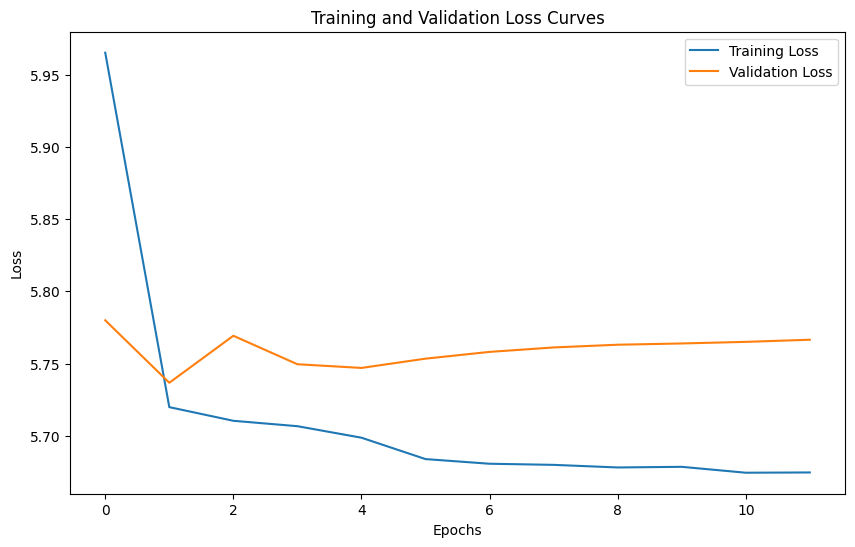

In [9]:
# Plot Training and Validation Loss Curves
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.show()

# Evaluation

Evaluate the model on the test set and display metrics.


In [ ]:
# Evaluate the model
test_dataset = ASLDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, shuffle=False)
model.eval()
test_loss = 0
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, targets = batch
        inputs, targets = inputs.to(device), targets.to(device)  # Move inputs to device too
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
test_loss /= len(test_loader)
accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Save the model for transfer learning
os.makedirs('./models', exist_ok=True)  # Create directory if it doesn't exist
torch.save({
    'model_state_dict': model.state_dict(),
    'input_size': input_size,
    'hidden_size': best_hidden_size,
    'dropout_rate': best_dropout_rate,
    'output_size': output_size,
    'accuracy': accuracy
}, "./models/transfer_learning_model.pth")
print("Model saved for transfer learning!")

Test Loss: 5.1280, Test Accuracy: 0.0187
Model saved for transfer learning!


# Inference

Test the model on new data or perform real-time inference.


In [ ]:
# Example inference
model.eval()
sample = torch.tensor(X_test[0:1], dtype=torch.float32).to(device)  # Move sample to the correct device
with torch.no_grad():
    prediction = model(sample)
    predicted_label = torch.argmax(prediction, dim=1).item()
print(f"Predicted label: {predicted_label}, True label: {y_test[0]}")

Predicted label: 177, True label: 115
